In [2]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import re
import jieba
from gensim.models import KeyedVectors
import warnings
warnings.filterwarnings("ignore")
import bz2
import pandas as pd
import tensorflow as tf
from sklearn.model_selection import train_test_split


from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Dense, Input, GlobalMaxPooling1D
from tensorflow.keras.layers import LSTM, Embedding
from tensorflow.keras.models import Model

from tensorflow.python.keras.models import Sequential
from tensorflow.python.keras.layers import Dense, GRU, Embedding, LSTM, Bidirectional
from tensorflow.python.keras.preprocessing.text import Tokenizer
from tensorflow.python.keras.preprocessing.sequence import pad_sequences
from tensorflow.python.keras.optimizers import RMSprop
from tensorflow.python.keras.optimizers import Adam
from tensorflow.python.keras.callbacks import EarlyStopping, ModelCheckpoint, TensorBoard, ReduceLROnPlateau



In [2]:
# 请将下载的词向量压缩包放置在根目录 embeddings 文件夹里
# 解压词向量, 有可能需要等待1-2分钟
with open("embeddings/sgns.zhihu.bigram", 'wb') as new_file, open("embeddings/sgns.zhihu.bigram.bz2", 'rb') as file:
    decompressor = bz2.BZ2Decompressor()
    for data in iter(lambda : file.read(100 * 1024), b''):
        new_file.write(decompressor.decompress(data))

In [2]:
# 使用gensim加载预训练中文分词embedding, 有可能需要等待1-2分钟
cn_model = KeyedVectors.load_word2vec_format('embeddings/sgns.zhihu.bigram', 
                                             binary=False, unicode_errors="ignore")

In [4]:
df= pd.read_csv('./data/DXYRumors.csv')
df['rumor_data'] = df['title']+df['mainSummary']+df['body']
df= df.drop(["id","_id","summary","sourceUrl","crawlTime","title","mainSummary","summary","body"], axis=1)
# rename columns 
df.columns = ['rumor_labels', 'rumor_data']
df.head()

,rumor_labels,rumor_data
0,0,疫情期间大强度锻炼可提高抵抗力？国家体育总局体育科学研究所研究员徐建方：长时间大强度的运动，...
1,0,吃降压药会增加感染病毒的风险？丁香医生团队辟谣：目前没有任何动物和临床研究数据证实这种说法的...
2,0,疫情期间大强度锻炼可提高抵抗力？国家体育总局体育科学研究所研究员徐建方：长时间大强度的运动，...
3,0,改用吸痰机后，武汉死亡人数减半？刘良教授辟谣：没有干预过任何个例的临床治疗有传闻称：「病患遗...
4,0,吃降压药会增加感染病毒的风险？丁香医生团队辟谣：目前没有任何动物和临床研究数据证实这种说法的...


In [5]:
df['rumor_data'] = df.rumor_data.apply(lambda x: " ".join(jieba.cut(x)))
df.head()

Building prefix dict from the default dictionary ...
Loading model from cache C:\Users\cheng\AppData\Local\Temp\jieba.cache
Loading model cost 1.686 seconds.
Prefix dict has been built successfully.


,rumor_labels,rumor_data
0,0,疫情 期间 大 强度 锻炼 可 提高 抵抗力 ？ 国家体育总局 体育 科学 研究所 研究员 ...
1,0,吃 降压药 会 增加 感染 病毒 的 风险 ？ 丁香 医生 团队 辟谣 ： 目前 没有 任何...
2,0,疫情 期间 大 强度 锻炼 可 提高 抵抗力 ？ 国家体育总局 体育 科学 研究所 研究员 ...
3,0,改用 吸痰 机后 ， 武汉 死亡 人数 减半 ？ 刘良 教授 辟谣 ： 没有 干预 过 任何...
4,0,吃 降压药 会 增加 感染 病毒 的 风险 ？ 丁香 医生 团队 辟谣 ： 目前 没有 任何...


In [6]:
# create labels
Y = df['rumor_labels'].values
# split up the data
df_train, df_test, Ytrain, Ytest = train_test_split(df['rumor_data'], Y, test_size=0.33)

In [7]:
# Convert sentences to sequences
MAX_VOCAB_SIZE = 20000
tokenizer = Tokenizer(num_words=MAX_VOCAB_SIZE)
tokenizer.fit_on_texts(df.rumor_data)
# get word -> integer mapping
word2idx = tokenizer.word_index
V = len(word2idx)
print('Found %s unique tokens.' % V)
sequences_train = tokenizer.texts_to_sequences(df_train)
sequences_test = tokenizer.texts_to_sequences(df_test)

Found 3270 unique tokens.


In [8]:
# pad sequences so that we get a N x T matrix
data_train = pad_sequences(sequences_train)
print('Shape of data train tensor:', data_train.shape)
# get sequence length
T = data_train.shape[1]

data_test = pad_sequences(sequences_test, maxlen=T)
print('Shape of data test tensor:', data_test.shape)

Shape of data train tensor: (190, 141)
Shape of data test tensor: (94, 141)


In [9]:
embedding_dim = 300
# 只使用前20000个词
num_words = 20000
# 初始化embedding_matrix，之后在keras上进行应用
embedding_matrix = np.zeros((num_words, embedding_dim))
# embedding_matrix为一个 [num_words，embedding_dim] 的矩阵
# 维度为 50000 * 300
for i in range(num_words):
    embedding_matrix[i,:] = cn_model[cn_model.index2word[i]]
embedding_matrix = embedding_matrix.astype('float32')

#embedding_matrix = tf.convert_to_tensor(embedding_matrix, dtype=tf.float32)
embedding_matrix=np.asarray(embedding_matrix)
#embedding_matrix = tf.constant(embedding_matrix, dtype=tf.float32)

# 检查index是否对应，
# 输出300意义为长度为300的embedding向量一一对应
#print(np.sum( cn_model[cn_model.index2word[333]] == embedding_matrix[333] ))

# embedding_matrix的维度，
# 这个维度为keras的要求，后续会在模型中用到
print(embedding_matrix.shape)

(20000, 300)


In [13]:
model = Sequential()
model.add(Embedding(num_words,
                    embedding_dim,
                    weights=[embedding_matrix],
                    trainable=False))
model.add(Bidirectional(LSTM(units=64, return_sequences=True)))
model.add(LSTM(units=16, return_sequences=False))
model.add(Dense(3, activation='softmax'))

In [14]:
# Compile and fit
model.compile(
  loss='sparse_categorical_crossentropy',
  optimizer='adam',
  metrics=['accuracy']
)


print('Training model...')
r = model.fit(data_train, Ytrain, epochs=10, validation_data=(data_test, Ytest))

Training model...
Train on 190 samples, validate on 94 samples
Epoch 1/10
190/190 [==============================] - 15s 78ms/sample - loss: 0.8505 - accuracy: 0.6842 - val_loss: 0.7337 - val_accuracy: 0.7447
Epoch 2/10
190/190 [==============================] - 5s 27ms/sample - loss: 0.5861 - accuracy: 0.8211 - val_loss: 0.7404 - val_accuracy: 0.7447
Epoch 3/10
190/190 [==============================] - 5s 28ms/sample - loss: 0.5617 - accuracy: 0.8211 - val_loss: 0.7538 - val_accuracy: 0.7447
Epoch 4/10
190/190 [==============================] - 5s 29ms/sample - loss: 0.5538 - accuracy: 0.8211 - val_loss: 0.7494 - val_accuracy: 0.7447
Epoch 5/10
190/190 [==============================] - 5s 29ms/sample - loss: 0.5364 - accuracy: 0.8211 - val_loss: 0.7249 - val_accuracy: 0.7447
Epoch 6/10
190/190 [==============================] - 5s 27ms/sample - loss: 0.4982 - accuracy: 0.8211 - val_loss: 0.6983 - val_accuracy: 0.7447
Epoch 7/10
190/190 [==============================] - 5s 27ms/samp

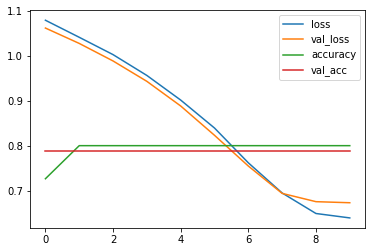

In [89]:
# Plot loss per iteration
import matplotlib.pyplot as plt
plt.plot(r.history['loss'], label='loss')
plt.plot(r.history['val_loss'], label='val_loss')
plt.legend()
# Plot accuracy per iteration
plt.plot(r.history['accuracy'], label='accuracy')
plt.plot(r.history['val_accuracy'], label='val_acc')
plt.legend()

In [97]:
txt = "吃汉堡能提高免疫力?丁香医生：胡说八道"
seq = tokenizer.texts_to_sequences([" ".join(jieba.cut(txt))])
padded = pad_sequences(seq, maxlen=141)
pred = model.predict(padded)
print(pred)

[[0.79859203 0.11008628 0.09132165]]


In [95]:
pad_sequences(seq, maxlen=20000)

array([[   0,    0,    0, ...,    0,    0,   63],
       [   0,    0,    0, ...,    0,    0,    0],
       [   0,    0,    0, ...,    0,    0,    0],
       ...,
       [   0,    0,    0, ...,    0,    0,  231],
       [   0,    0,    0, ...,    0,    0,    0],
       [   0,    0,    0, ...,    0,    0, 2992]])

In [ ]:
train_tokens = []
for rumor in df['rumor_data']:
    rumor = re.sub("[\s+\.\!\/_,$%^*(+\"\']+|[+——！，。？、~@#￥%……&*（）]+", "",rumor)
    # 结巴分词
    cut = jieba.cut(rumor)
    # 结巴分词的输出结果为一个生成器
    # 把生成器转换为list
    cut_list = [ i for i in cut ]
    for i, word in enumerate(cut_list):
        try:
            # 将词转换为索引index
            cut_list[i] = cn_model.vocab[word].index
        except KeyError:
            # 如果词不在字典中，则输出0
            cut_list[i] = 0
    train_tokens.append(cut_list)

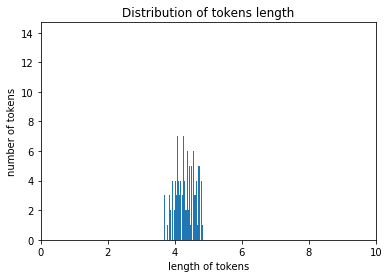

In [64]:
num_tokens = [ len(tokens) for tokens in train_tokens ]
num_tokens = np.array(num_tokens)
# 平均tokens的长度
np.mean(num_tokens)
# 最长的评价tokens的长度
np.max(num_tokens)
plt.hist(np.log(num_tokens), bins = 100)
plt.xlim((0,10))
plt.ylabel('number of tokens')
plt.xlabel('length of tokens')
plt.title('Distribution of tokens length')
plt.show()

In [67]:
# 取tokens平均值并加上两个tokens的标准差，
# 假设tokens长度的分布为正态分布，则max_tokens这个值可以涵盖95%左右的样本
max_tokens = np.mean(num_tokens) + 2 * np.std(num_tokens)
max_tokens = int(max_tokens)
print(max_tokens)

# 取tokens的长度为236时，大约95%的样本被涵盖
# 我们对长度不足的进行padding，超长的进行修剪
np.sum( num_tokens < max_tokens ) / len(num_tokens)

120


0.9753521126760564

In [3]:
df= pd.read_csv('./data/DXYRumors.csv')
df['rumor_data'] = df['title']+df['mainSummary']+df['body']
df= df.drop(["id","_id","summary","sourceUrl","crawlTime","title","mainSummary","summary","body"], axis=1)
# rename columns 
df.columns = ['rumor_labels', 'rumor_data']
df.head()

,rumor_labels,rumor_data
0,0,疫情期间大强度锻炼可提高抵抗力？国家体育总局体育科学研究所研究员徐建方：长时间大强度的运动，...
1,0,吃降压药会增加感染病毒的风险？丁香医生团队辟谣：目前没有任何动物和临床研究数据证实这种说法的...
2,0,疫情期间大强度锻炼可提高抵抗力？国家体育总局体育科学研究所研究员徐建方：长时间大强度的运动，...
3,0,改用吸痰机后，武汉死亡人数减半？刘良教授辟谣：没有干预过任何个例的临床治疗有传闻称：「病患遗...
4,0,吃降压药会增加感染病毒的风险？丁香医生团队辟谣：目前没有任何动物和临床研究数据证实这种说法的...


In [4]:
news= pd.read_csv('./data/DXY_news.csv')
news.head()
news['news_data'] = news['title']+news['summary']
news= news.drop(["_id","id","title","pubDate","summary","infoSource","sourceUrl","provinceId","crawlTime","entryWay","infoType","dataInfoState","dataInfoOperator","dataInfoTime","provinceName","createTime","modifyTime","adoptType","body"], axis=1)
# rename columns 
news.columns = [ 'label','news_data']
news.head()

,label,news_data
0,3,世卫组织：全球新冠肺炎超过769万例根据世卫组织最新实时统计数据，截至欧洲中部夏令时间6月1...
1,3,北京机场巴士公司声明：确诊病例未与公司人员及任何旅客有过接触据机场巴士官方平台微信公众号6月...
2,3,土耳其疫情暴发以来首次举行大规模全国性考试，45万考生参加当地时间6月14日，土耳其举行国防...
3,3,印度德里计划改造酒店，增加2万张病床印度德里首都辖区政府：将在未来一周内通过改造全市的酒店和...
4,3,世卫组织：全球新冠肺炎确诊病例超过763万例根据世卫组织最新实时统计数据，截至欧洲中部夏令时...


In [ ]:
res1=pd.concat([df,news],axis=1,ignore_index=True)